# Kaggle Challenge
# #4 Car Object Detection using YOLO V5

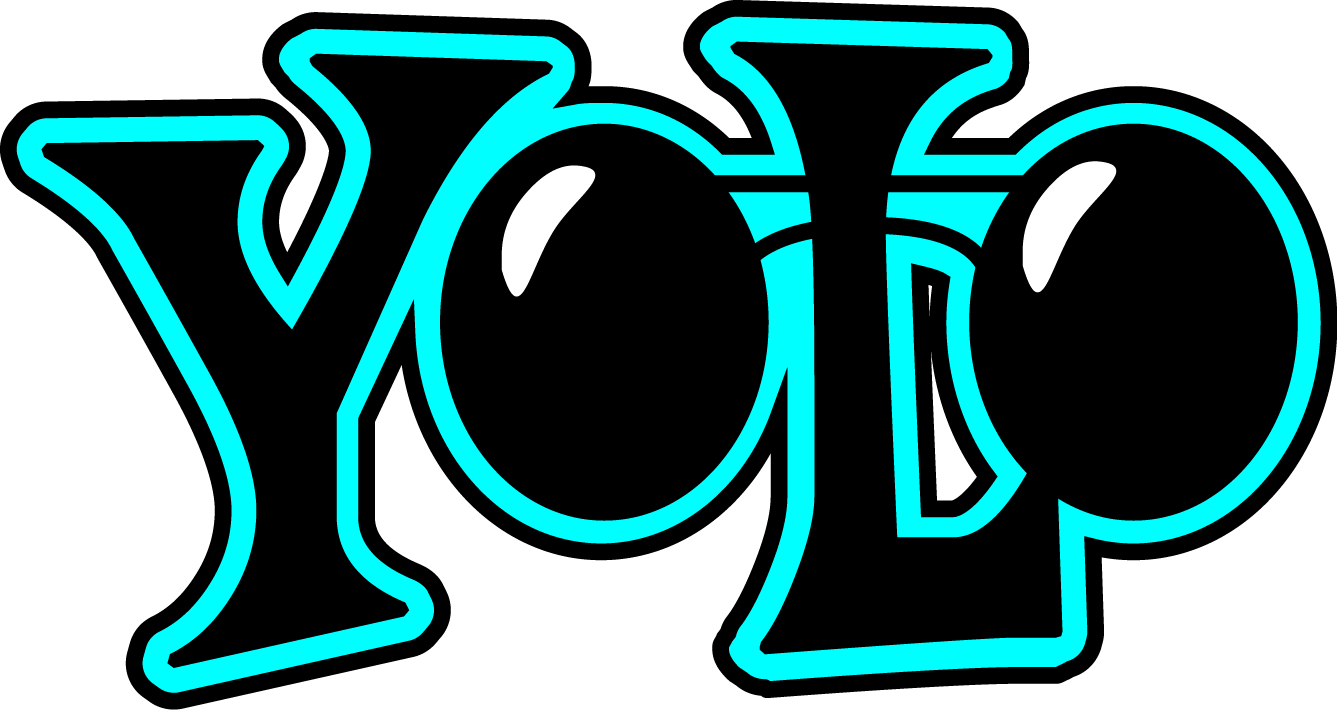

YOLO 는 You Only Look Once 의 약자로, 매우 빠른 속도의 object detection 이 가능한 딥러닝 알고리즘이다. 현재 가장 최신 버전이 V5 이기 때문에 Car Detection 을 YOLO V5 로 진행하고자 했다.

## 1. 라이브러리 불러오기

In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm  # tqdm: for 문의 상태바를 나타내주는 라이브러리
import shutil as sh         # shutil: 파일 또는 폴더를 복사할 때 필요한 라이브러리

from IPython.display import Image, clear_output  # IPython = Python Shell
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Git Clone 을 통해 YOLO V5 설치하기

In [2]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [3]:
!pip install -qr yolov5/requirements.txt

## 3. Bounding Box Data 전처리하기

In [4]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('/home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764800,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020261,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


## 4. training image 랜덤 불러오고 이미지 확인하기

In [5]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_4560


(380, 676, 3)

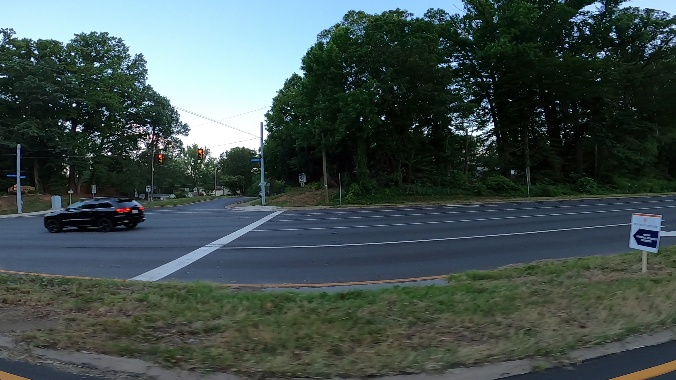

In [6]:
Image(filename=f'/home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/training_images/{image}.jpg', width = 600)

## 5. 학습하기

In [7]:
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/{}/{}.jpg".format(source,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

In [8]:
!python '/home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/yolov5/train.py' --batch 2 --epochs 1 --data '/home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/yolov5/data/coco.yaml' --cfg '/home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/yolov5/models/yolov5x.yaml' --name yolov5x_fold0_new

Using CPU

Namespace(adam=False, batch_size=2, bucket='', cache_images=False, cfg='/home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/yolov5/models/yolov5x.yaml', data='/home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/yolov5/data/coco.yaml', device='', epochs=1, evolve=False, global_rank=-1, hyp='./yolov5/data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], local_rank=-1, logdir='runs/', multi_scale=False, name='yolov5x_fold0_new', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=2, weights='yolov5s.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
2020-09-05 17:16:58.647400: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.

## 6. 예측하기

In [9]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source '/home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images'

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=676, iou_thres=0.5, output='inference/output', save_txt=False, source='/home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images', update=False, view_img=False, weights=['yolov5/yolov5s.pt'])
Using CPU

100%|██████████████████████████████████████| 14.5M/14.5M [00:06<00:00, 2.28MB/s]

Fusing layers... 
Model Summary: 140 layers, 7.45958e+06 parameters, 6.61683e+06 gradients
image 1/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_25100.jpg: 448x704 Done. (0.145s)
image 2/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_25120.jpg: 448x704 Done. (0.124s)
image 3/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_25140.jpg: 448x704 Done. (0.125s)
image 4/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_25160.jpg: 448x704 Done. (0.127s)

image 56/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_27680.jpg: 448x704 Done. (0.170s)
image 57/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_27700.jpg: 448x704 Done. (0.146s)
image 58/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_27720.jpg: 448x704 Done. (0.122s)
image 59/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_27740.jpg: 448x704 Done. (0.121s)
image 60/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_27760.jpg: 448x704 Done. (0.117s)
image 61/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_27780.jpg: 448x704 Done. (0.116s)
image 62/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_27800.jpg: 448x704 Done. (0.113s)
image 63/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_27

image 118/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_29740.jpg: 448x704 Done. (0.160s)
image 119/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_29760.jpg: 448x704 1 cars, Done. (0.146s)
image 120/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_29820.jpg: 448x704 1 cars, Done. (0.128s)
image 121/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_29840.jpg: 448x704 1 cars, Done. (0.134s)
image 122/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_29860.jpg: 448x704 Done. (0.157s)
image 123/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_29880.jpg: 448x704 Done. (0.132s)
image 124/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detection/data/testing_images/vid_5_29900.jpg: 448x704 Done. (0.130s)
image 125/175 /home/lifeofpy/LifeofPy/Kaggle/4. YOLO V5 Car Detect

In [10]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("inference/output"):
    predicted_files.extend(filenames)

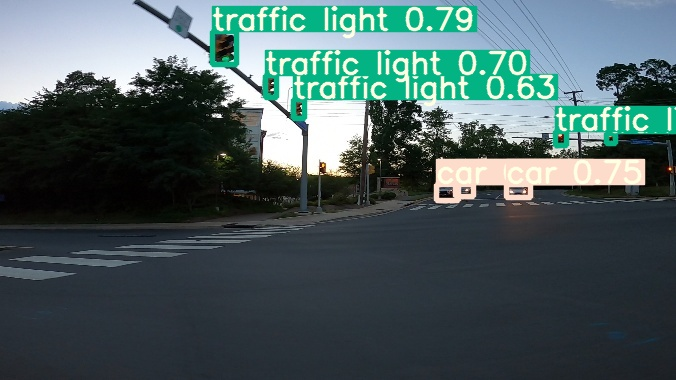

In [11]:
Image(filename=f'inference/output/{random.choice(predicted_files)}')

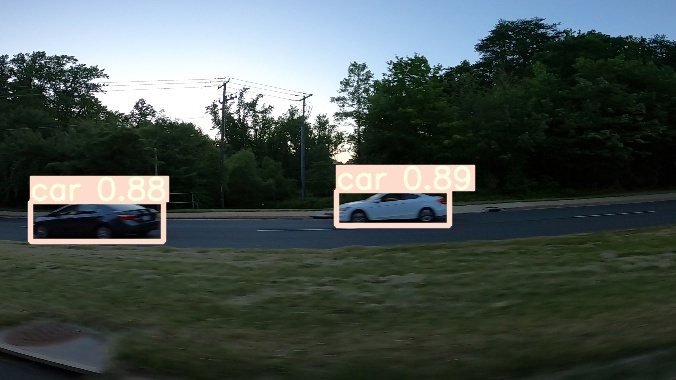

In [12]:
Image(filename=f'inference/output/{random.choice(predicted_files)}')

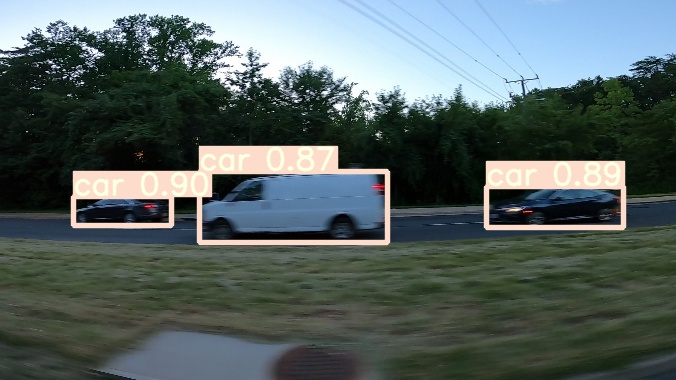

In [13]:
Image(filename=f'inference/output/{random.choice(predicted_files)}')

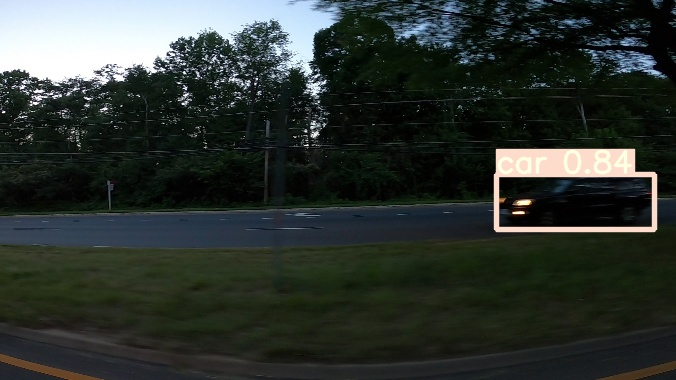

In [14]:
Image(filename=f'inference/output/{random.choice(predicted_files)}')

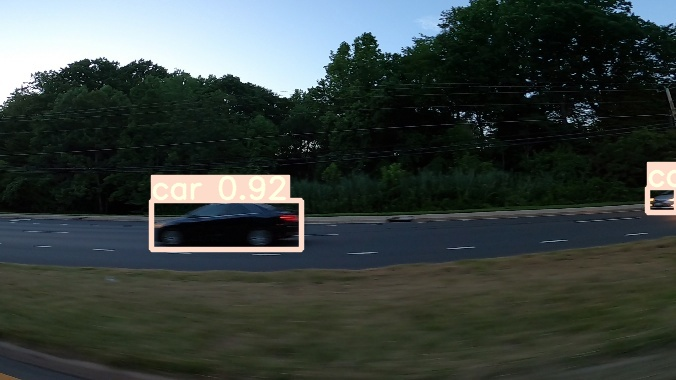

In [15]:
Image(filename=f'inference/output/{random.choice(predicted_files)}')

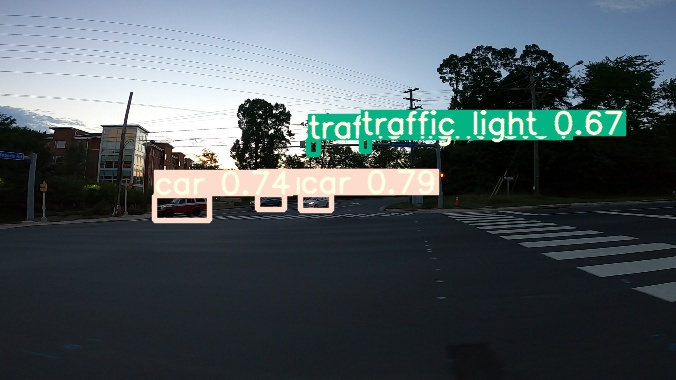

In [23]:
Image(filename=f'inference/output/{random.choice(predicted_files)}')